In [409]:
import pandas as pd
import numpy as np
import datetime
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

pd.set_option('display.max_columns', None)
from feature_engine.imputation import RandomSampleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score

In [410]:
data = pd.read_excel("creditcardmarketing.xlsx")
data.head()

Customer Number Offer Accepted     Reward Mailer Type Income Level  \
0                1             No  Air Miles      Letter         High   
1                2             No  Air Miles      Letter       Medium   
2                3             No  Air Miles    Postcard         High   
3                4             No  Air Miles      Letter       Medium   
4                5             No  Air Miles      Letter       Medium   

   # Bank Accounts Open Overdraft Protection Credit Rating  \
0                     1                   No          High   
1                     1                   No        Medium   
2                     2                   No        Medium   
3                     2                   No          High   
4                     1                   No        Medium   

   # Credit Cards Held  # Homes Owned  Household Size Own Your Home  \
0                    2              1               4            No   
1                    2              2               5           Yes   
2                    2              1               2           Yes   
3                    1              1               4            No   
4                    2              1               6           Yes   

   Average Balance  Q1 Balance  Q2 Balance  Q3 Balance  Q4 Balance  
0          1160.75      1669.0       877.0      1095.0      1002.0  
1           147.25        39.0       106.0        78.0       366.0  
2           276.50       367.0       352.0       145.0       242.0  
3          1219.00      1578.0      1760.0      1119.0       419.0  
4          1211.00      2140.0      1357.0       982.0       365.0

In [411]:
data.shape

(18000, 17)

In [412]:
# Formatting column names
data.columns = list(map(lambda x: x.lower().replace("# ","").replace(" ","_"), data.columns))
data.columns

Index(['customer_number', 'offer_accepted', 'reward', 'mailer_type',
       'income_level', 'bank_accounts_open', 'overdraft_protection',
       'credit_rating', 'credit_cards_held', 'homes_owned', 'household_size',
       'own_your_home', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance'],
      dtype='object')

In [413]:
# Checking dtype of the columns and for nans
print(data.dtypes)
print("===========================")
print(data.isna().sum())

customer_number           int64
offer_accepted           object
reward                   object
mailer_type              object
income_level             object
bank_accounts_open        int64
overdraft_protection     object
credit_rating            object
credit_cards_held         int64
homes_owned               int64
household_size            int64
own_your_home            object
average_balance         float64
q1_balance              float64
q2_balance              float64
q3_balance              float64
q4_balance              float64
dtype: object
customer_number          0
offer_accepted           0
reward                   0
mailer_type              0
income_level             0
bank_accounts_open       0
overdraft_protection     0
credit_rating            0
credit_cards_held        0
homes_owned              0
household_size           0
own_your_home            0
average_balance         24
q1_balance              24
q2_balance              24
q3_balance              24
q4_balance

In [414]:
# Checking value counts bank_accounts_open, credit_cards_held, homes_owned, household_size
for col in ["bank_accounts_open","credit_cards_held","homes_owned","household_size"]:
    print(data[col].value_counts())

1    13692
2     4012
3      296
Name: bank_accounts_open, dtype: int64
2    7944
1    6154
3    3387
4     515
Name: credit_cards_held, dtype: int64
1    14523
2     3292
3      185
Name: homes_owned, dtype: int64
3    5712
4    5543
5    2853
2    2813
1     539
6     538
8       1
9       1
Name: household_size, dtype: int64


In [415]:
# Based on the first observation
# 1- customer_number is not needed
data.drop(["customer_number"],axis=1, inplace=True)
# 2- offer_accepted is the target based on the business requirements
# 3- bank_accounts_open, credit_cards_held, homes_owned, household_size can be categorical
# 4- Last four columns has nan values, will replace them using RandomSampleImputer

In [416]:
# Changing bank_accounts_open to categorical
bao_bins = [0,1,2,3]
bao_labels = ["Few","Moderate","Many"]
data['bank_accounts_open_'] = pd.cut(data['bank_accounts_open'], bins=bao_bins, labels=bao_labels)
data['bank_accounts_open_'] = data['bank_accounts_open_'].astype('object')
# Dropping original column
data.drop(["bank_accounts_open"], axis=1, inplace=True)
data["bank_accounts_open_"].value_counts()

Few         13692
Moderate     4012
Many          296
Name: bank_accounts_open_, dtype: int64

In [417]:
# Changing credit_cards_held to categorical
cch_bins = [0, 1, 2, 3, 4]
cch_labels = ["Minimal","Low","Moderate","High"]
data['credit_cards_held_'] = pd.cut(data['credit_cards_held'], bins=cch_bins, labels=cch_labels)
data['credit_cards_held_'] = data['credit_cards_held_'].astype('object')
# Dropping original column
data.drop(["credit_cards_held"], axis=1, inplace=True)
data["credit_cards_held_"].value_counts()

Low         7944
Minimal     6154
Moderate    3387
High         515
Name: credit_cards_held_, dtype: int64

In [418]:
# Changing homes_owned to categorical
ho_bins = [0, 1, 2, 3]
ho_labels = ["One","Two","Three"]
data['homes_owned_'] = pd.cut(data['homes_owned'], bins=ho_bins, labels=ho_labels)
data['homes_owned_'] = data['homes_owned_'].astype('object')
# Dropping original column
data.drop(["homes_owned"], axis=1, inplace=True)
data["homes_owned_"].value_counts()

One      14523
Two       3292
Three      185
Name: homes_owned_, dtype: int64

In [419]:
# Changing household_size to categorical
# column has 2 outliers with 1 value each, filtering and dropping those records
data = data[data["household_size"] <= 6]
hs_bins = [0, 2, 4, 6]
hs_labels = ['Small', 'Medium', 'Large']
data['household_size_'] = pd.cut(data['household_size'], bins=hs_bins, labels=hs_labels)
data['household_size_'].astype('object')
# Dropping original column
data.drop(["household_size"], axis=1, inplace=True)
data["household_size_"].value_counts()

Medium    11255
Large      3391
Small      3352
Name: household_size_, dtype: int64

In [420]:
# Solving nan Values -----
# Since the amount of nan's is 120 total, compared to the total records of 18,000 I will proceed
# with using RandomSampleImputer to replace nan values with random sample data from the dataframe
imputer = RandomSampleImputer(random_state=42)
data = imputer.fit_transform(data)
data.isna().sum()

offer_accepted          0
reward                  0
mailer_type             0
income_level            0
overdraft_protection    0
credit_rating           0
own_your_home           0
average_balance         0
q1_balance              0
q2_balance              0
q3_balance              0
q4_balance              0
bank_accounts_open_     0
credit_cards_held_      0
homes_owned_            0
household_size_         0
dtype: int64

In [421]:
# Remove outliers function
def process_outliers(df,col,limit = 3,u_iqr = 1.5,l_iqr = 1.5, remove=True):
    print(f"Using limit: {limit},u_iqr: {u_iqr}, l_iqr: {l_iqr}")
    
    iqr = np.percentile(df[col], 75) - np.percentile(df[col], 25)
    u_limit = np.percentile(df[col], 75) + u_iqr*iqr
    l_limit = np.percentile(df[col], 25) - l_iqr*iqr
    outliers = df[(df[col]<l_limit) | (df[col]>u_limit)]
    
    # Check what percentage of the data will be removed by cleaning the ourliers
    percentage_outliers = outliers.shape[0]/df.shape[0]*100
    print("DataFrame shape:",df.shape)
    print("Column ",col,"outliers shape:",outliers.shape)
    print("Outliers rows ""%",percentage_outliers)
    
    if percentage_outliers < limit:        
        mask = (df[col] >= l_limit) & (df[col] <= u_limit)

        filtered_df = df[mask]
        print(f"Removed {df.shape[0] - filtered_df.shape[0]} rows")
        print(sns.boxplot(y=col, data=filtered_df))
        
        if remove:
            return filtered_df
        else:
            return df
    else:
        print(f"No outliers removed, exceeding limit of {limit}%")
        return df;

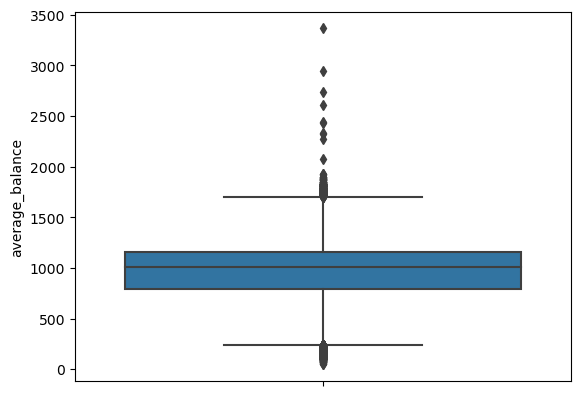

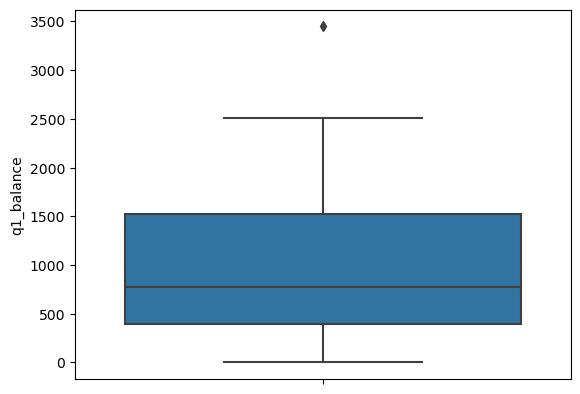

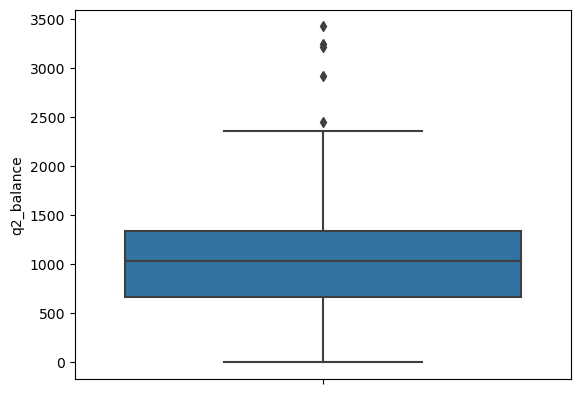

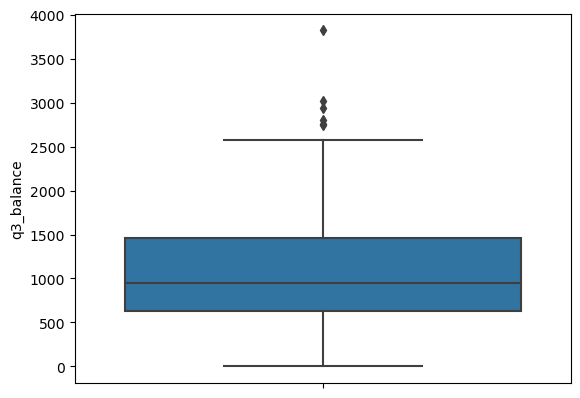

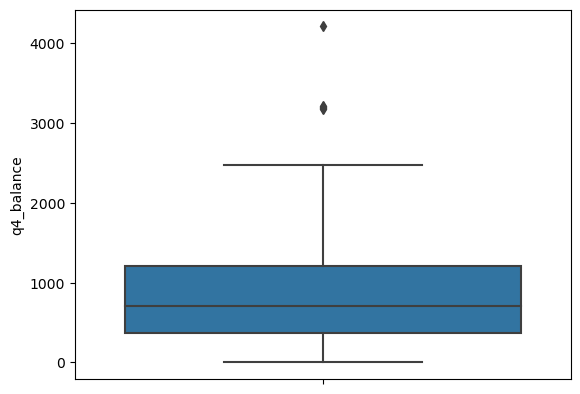

In [422]:
# Checking for outliers
for col in data.select_dtypes(np.number).columns:
    sns.boxplot(y=col, data= data.select_dtypes(np.number))
    plt.show()

In [423]:
# Create data backup before proceeding
data_bak1 = data

Using limit: 4,u_iqr: 1.5, l_iqr: 1.67
DataFrame shape: (17998, 16)
Column  average_balance outliers shape: (715, 16)
Outliers rows % 3.972663629292143
Removed 715 rows
Axes(0.125,0.11;0.775x0.77)


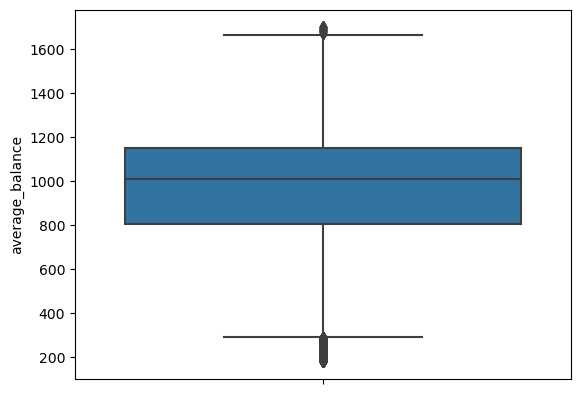

In [424]:
# Column: average_balance
data = process_outliers(data,"average_balance", 4,1.5,1.67,True)

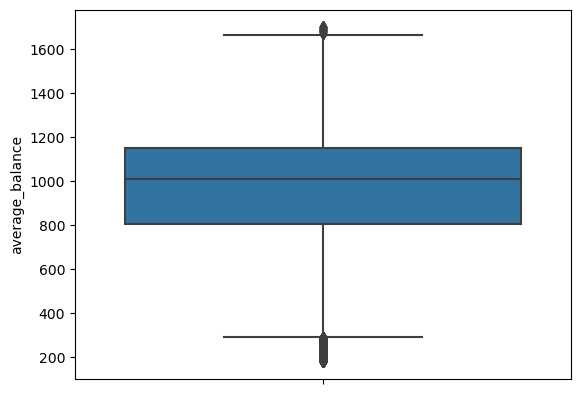

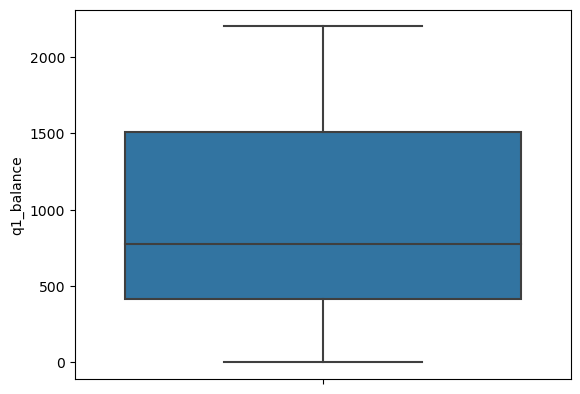

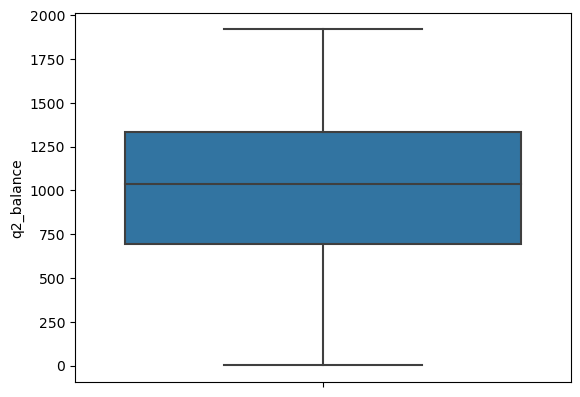

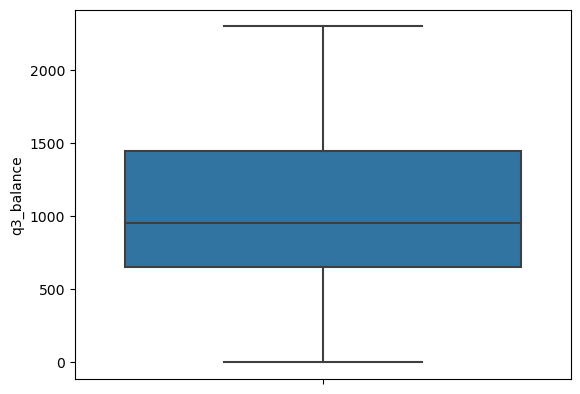

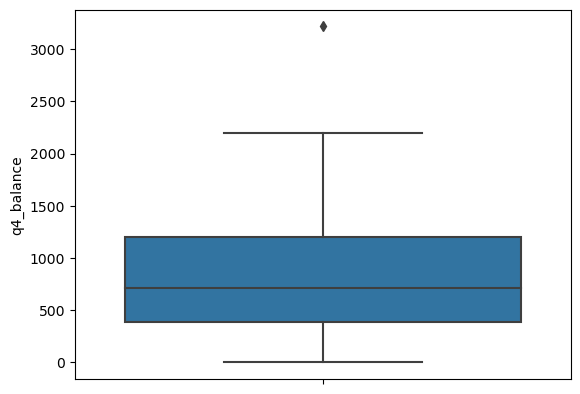

In [425]:
# Checking for outliers again to see how it impacted the other columns
for col in data.select_dtypes(np.number).columns:
    sns.boxplot(y=col, data= data.select_dtypes(np.number))
    plt.show()

Using limit: 4,u_iqr: 1.5, l_iqr: 1.5
DataFrame shape: (17283, 16)
Column  q4_balance outliers shape: (1, 16)
Outliers rows % 0.005786032517502748
Removed 1 rows
Axes(0.125,0.11;0.775x0.77)


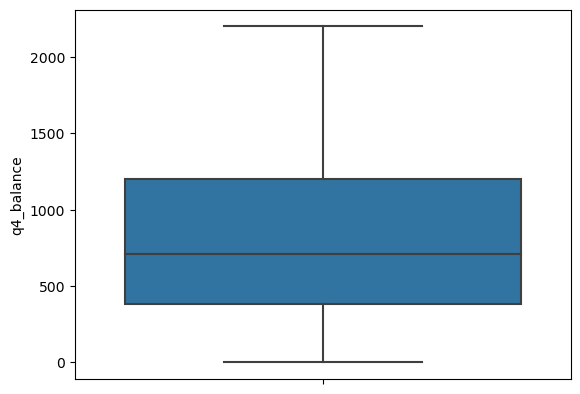

In [426]:
# Removing 1 outlier for q4_balance
data = process_outliers(data,"q4_balance", 4,1.5,1.5,True)

<Axes: >

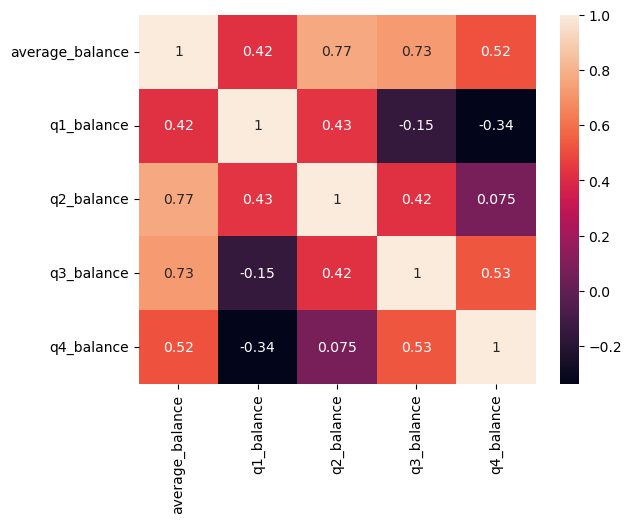

In [427]:
# Checking correlation
sns.heatmap(data.select_dtypes(np.number).corr(method="pearson"), annot=True)

In [428]:
# Dropping column average_balance due to high correlation between 2 other columns
data.drop(["average_balance"], axis=1, inplace=True)

In [429]:
# Running chi2 for every categorical column with the target
for col in data.select_dtypes("object").columns:
    # Running chi2
    crosstab_table = pd.crosstab(data[col], data['offer_accepted'])
    # Perform the test
    stat, p_value, dof, expected = chi2_contingency(crosstab_table)
    # Print results
    print(f"column: {col}, p-value: {p_value}")

column: offer_accepted, p-value: 0.0
column: reward, p-value: 1.1399196312282074e-21
column: mailer_type, p-value: 4.018347743068315e-38
column: income_level, p-value: 7.630213130703139e-25
column: overdraft_protection, p-value: 0.5756668996240613
column: credit_rating, p-value: 1.2784994151799617e-93
column: own_your_home, p-value: 0.8921378040029516
column: bank_accounts_open_, p-value: 0.6643107814112417
column: credit_cards_held_, p-value: 0.7021791691732744
column: homes_owned_, p-value: 0.5845681863986334


In [430]:
# After running chi2, noticed multiple columns that doesn't fall below 0.5
# homes_owned_, credit_cards_held_, bank_accounts_open_, own_your_home and overdraft_protection
# TODO: Run models with the columns and without to compare results

In [431]:
#data.drop(["homes_owned_","credit_cards_held_","bank_accounts_open_","own_your_home", "overdraft_protection"], axis=1, inplace=True)

In [432]:
# Data transformation
# First we separate categoricals, numericals and the target
target = data["offer_accepted"]
# Removing target
data.drop(["offer_accepted"], axis=1, inplace=True)
#
numericals = data.select_dtypes(np.number)
categoricals = data.select_dtypes("object")

In [433]:
# Categoricals encoding
categoricals_encoded = OneHotEncoder(drop='first').fit_transform(categoricals).toarray()
categoricals_encoded_df = pd.DataFrame(categoricals_encoded)
categoricals_encoded_df.head(100)

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1   0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0   
96  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
97  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
98  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
99  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   

     15  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  
..  ...  
95  0.0  
96  0.0  
97  0.0  
98  1.0  
99  0.0  

[100 rows x 16 columns]

In [434]:
# Numericals encoding
numericals_scaled_df = StandardScaler().fit_transform(numericals)
numericals_scaled_df = pd.DataFrame(scaled)
numericals_scaled_df.head(10)

0         1         2         3
0  1.234187 -0.302778  0.079731  0.351197
1 -0.899229 -1.515163 -1.692680 -1.044477
2  1.085077  1.736338  0.124508 -0.719432
3  2.005953  0.805688 -0.131093 -0.818599
4  1.525852  0.824163 -0.563934 -0.576192
5 -0.733734 -1.893890 -1.315809 -1.246483
6 -1.284293 -1.425101 -1.431482 -0.926947
7 -0.035704 -0.270448 -0.317662  0.995778
8  1.471779  1.029691 -1.004238 -1.277702
9 -0.251995 -0.418244  0.749515  1.262058

In [435]:
# # Concatenating both processed dataframes
features_encoded = pd.concat([categoricals_encoded_df, numericals_scaled_df], axis = 1)
# Training
x_train, x_test, y_train, y_test = train_test_split(features_encoded , target, test_size=.2, random_state=10)

In [444]:
# Decided to use LogisticRegression as a baseline, others 2 are more suitable for the
def run_algorithms(x_train, y_train,x_test, neighbors = 5):
    dtc = DecisionTreeClassifier()
    lr = LogisticRegression()
    kn = KNeighborsClassifier(n_neighbors=neighbors)
    
    models = [dtc,lr,kn]
    
    for model in models:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        print(f"{model} score: {accuracy_score(y_test,y_pred)}")

In [449]:
run_algorithms(x_train, y_train, x_test, 7)

DecisionTreeClassifier() score: 0.8947063928261498
LogisticRegression() score: 0.9459068556551924
KNeighborsClassifier(n_neighbors=7) score: 0.9456175875036158


In [438]:
# Scores removing the categoricals in the chi2 step

# DecisionTreeClassifier() score: 0.8955741972808794
# LogisticRegression() score: 0.9459068556551924
# KNeighborsClassifier() score: 0.9427249059878507

[0.9409892970783916, 0.9459068556551924, 0.9459068556551924, 0.9459068556551924, 0.9459068556551924, 0.9459068556551924, 0.9459068556551924, 0.9459068556551924, 0.9459068556551924, 0.9459068556551924]


Text(0, 0.5, 'Accuracy')

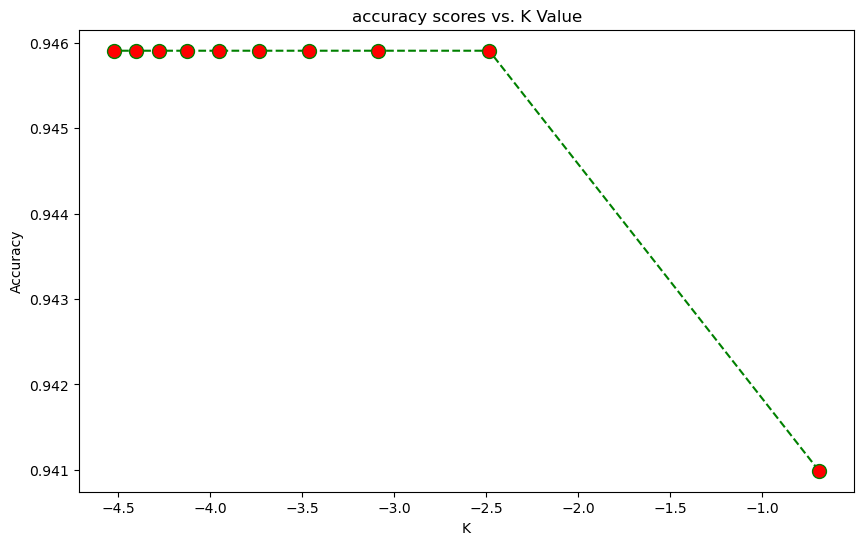

In [450]:
# Deeper with KNeighbors
scores = []
complexity = []
for i in range(2,100, 10):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    score = accuracy_score(y_test,y_pred)
    
    complexity.append(np.log(1/i))
    scores.append(score)
print(scores)
plt.figure(figsize=(10,6))
plt.plot(complexity,scores,color = 'green',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy scores vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')